In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import datetime
import os
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from notebook_shared import utils
from notebook_shared import violinplotutil

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import Series

import seaborn as sns
sns.set()
matplotlib.style.use('seaborn-colorblind')

INPUT_FILE = "dataset"
FSIZE = "tiny"

df = pd.read_parquet(utils.get_dataset_path(INPUT_FILE, FSIZE))
# df['1_run_id'] = df['1_run_id'].astype('int64')
# df.sort_values(['driver_invocation', 'workload_invocation', 'provider', 'region', '1_run_id'], inplace=True, ignore_index=True)

In [3]:
df[['driver_invocation', 'workload_invocation', 'provider', 'region', '1_run_id']]

,driver_invocation,workload_invocation,provider,region,1_run_id
0,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,28
1,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,69
2,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,74
3,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,86
4,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,103
...,...,...,...,...,...
499531,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,19
499532,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,35
499533,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,83
499534,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,90


In [4]:
df.columns

Index(['driver_invocation', 'workload_invocation', 'provider', 'region',
       'dirty_measurement', 'folder_uuid', '1_run_id', '2_thread_id',
       'SAAFMemoryDeltaError', 'SAAFMemoryError', 'contextSwitches',
       'contextSwitchesDelta', 'cpuIdle', 'cpuIdleDelta', 'cpuIowait',
       'cpuIowaitDelta', 'cpuIrqDelta', 'cpuKrn', 'cpuKrnDelta', 'cpuModel',
       'cpuNice', 'cpuSoftIrq', 'cpuSoftIrqDelta', 'cpuType', 'cpuUsr',
       'cpuUsrDelta', 'endTime', 'frameworkRuntime', 'frameworkRuntimeDeltas',
       'freeMemory', 'functionName', 'latency', 'linuxVersion', 'newcontainer',
       'roundTripTime', 'runtime', 'runtimeOverlap', 'startTime',
       'totalMemory', 'userRuntime', 'uuid', 'vmcpusteal', 'vmcpustealDelta',
       'vmuptime', 'containerID', 'functionMemory', 'pageFaults',
       'pageFaultsDelta', 'vmID', 'dow_utc', 'tod_utc', 'timezone',
       'measure group', 'local_dow', 'local_tod'],
      dtype='object')

In [5]:
# Common Stuff
provider_region_mapping = {}
provider_region_mg_df = df.groupby( ['provider', 'region'], observed=True)['measure group'].unique().reset_index()
provider_region_mg_df
for index, row in provider_region_mg_df.iterrows():
    for measure_group in row['measure group']:
        region = row['region']
        provider = row['provider']
        measure_group = row['measure group'][0]
        provider_region_mapping[f"({provider}, {region})"] = {'region': region, 'measure group': measure_group, 'provider': provider}
        provider_region_mapping[f"({provider}, {region}, {measure_group})"] = {'region': region, 'measure group': measure_group, 'provider': provider}

# Mean Runtime and CV Per Provider
- Q: Has a provider a overall characterstics or do specific regions stand out?
- Q: Does have one provider an overall more volatile region?

In [6]:
cov_df = df.groupby( ['provider', 'region'], observed=True)['runtime'].apply(utils.cov)

AWS


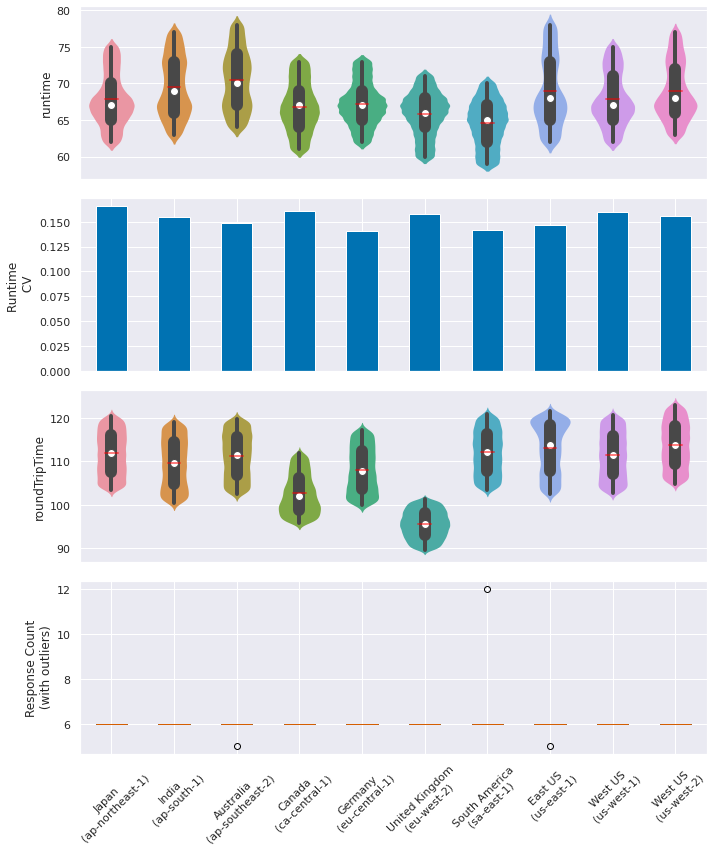

runtimebx 
                         runtime                                               \
                          count       mean       std   min   25%   50%   75%   
provider region                                                                
AWS      ap-northeast-1  9345.0  67.828036  3.549471  62.0  65.0  67.0  70.0   
         ap-south-1      9049.0  69.572881  4.030336  63.0  66.0  69.0  73.0   
         ap-southeast-2  9408.0  70.475553  4.010277  64.0  67.0  70.0  74.0   
         ca-central-1    8745.0  66.825386  3.381512  61.0  64.0  67.0  69.0   
         eu-central-1    9057.0  67.253285  2.960782  62.0  65.0  67.0  69.0   
         eu-west-2       9208.0  65.848719  2.994297  60.0  64.0  66.0  68.0   
         sa-east-1       9188.0  64.531672  3.121148  59.0  62.0  65.0  67.0   
         us-east-1       9390.0  68.945154  4.672155  62.0  65.0  68.0  73.0   
         us-west-1       9030.0  67.897896  3.594335  62.0  65.0  67.0  71.0   
         us-west-2       941

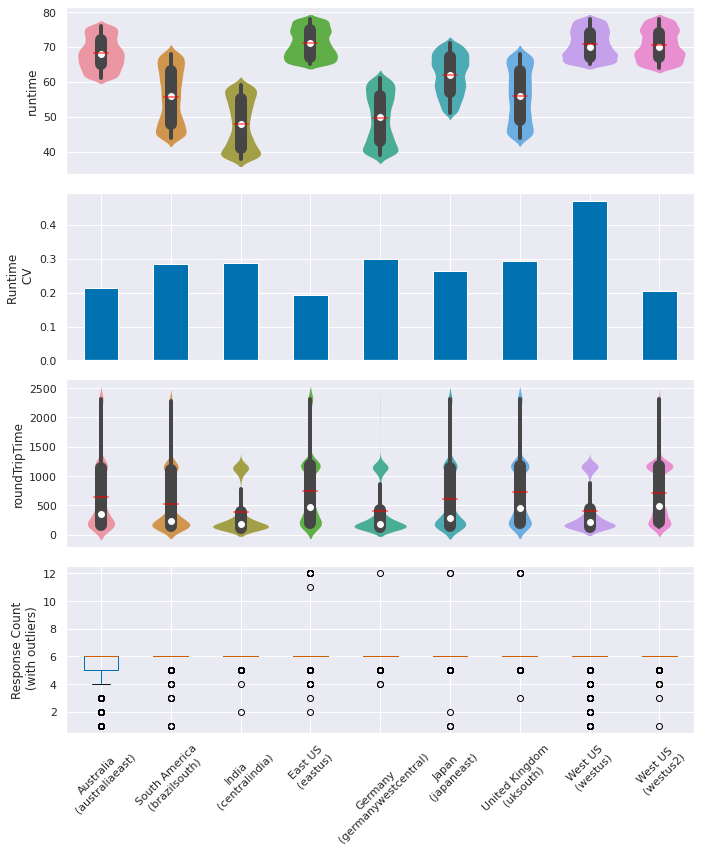

runtimebx 
                             runtime                                         \
                              count       mean       std   min   25%   50%   
provider region                                                              
AZURE    australiaeast       7506.0  68.190514  4.410024  61.0  65.0  68.0   
         brazilsouth         8870.0  55.755017  7.831584  44.0  48.0  56.0   
         centralindia        8833.0  47.949734  7.062910  38.0  41.0  48.0   
         eastus              9143.0  71.009297  4.029211  65.0  67.0  71.0   
         germanywestcentral  9075.0  49.501708  7.134564  39.0  43.0  50.0   
         japaneast           9011.0  61.955166  5.608796  51.0  57.0  62.0   
         uksouth             9014.0  56.034835  7.519928  44.0  49.0  56.0   
         westus              8537.0  70.820780  3.990320  65.0  67.0  70.0   
         westus2             9151.0  70.528248  4.229204  64.0  67.0  70.0   

                                         
         

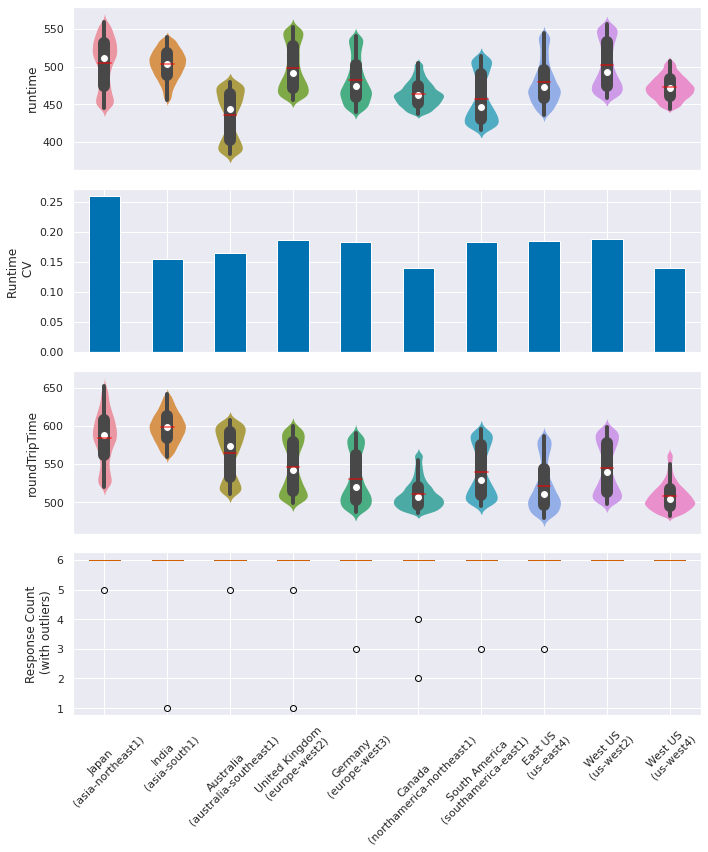

runtimebx 
                                  runtime                                       \
                                   count        mean        std    min    25%   
provider region                                                                 
GCP      asia-northeast1          8772.0  504.495554  33.065054  445.0  474.0   
         asia-south1              8721.0  502.768375  19.807063  455.0  489.0   
         australia-southeast1     8827.0  434.982554  32.111576  383.0  402.0   
         europe-west2             8806.0  498.544402  30.498896  456.0  471.0   
         europe-west3             8796.0  481.524329  28.796839  440.0  459.0   
         northamerica-northeast1  8775.0  463.632707  15.965983  437.0  452.0   
         southamerica-east1       8804.0  457.245457  31.880828  416.0  430.0   
         us-east4                 8753.0  479.848395  28.409398  436.0  458.0   
         us-west2                 8779.0  501.491742  31.320774  458.0  474.0   
         us-west

In [7]:
for provider in df['provider'].unique():
    SHAREX = True
    fig, axes = plt.subplots(figsize=(10,12), nrows=4, frameon=False, sharex=SHAREX)
    
    # Runtime
    # bxdf = df[['provider', 'region', 'runtime']][df['provider'] == provider].groupby(['provider','region'], observed=True)
    # utils.boxplot(axes[0], bxdf, "Runtime\n Boxplots", lambda x: x, rot=90, sharex=SHAREX)
    # vioplot(df, provider)
    pdf = df[['provider', 'region', 'runtime']][df['provider'] == provider]
    pdf = utils.remove_outliers_group_quantiles(pdf, 'region', 'runtime')
    violinplotutil.vioplot(pdf, axes[0], 'runtime')
    
    bxdf = pdf.groupby(['provider','region'], observed=True)
    
    # COV
    cov_provider = cov_df.loc[provider]
    cov_provider.plot(kind='bar', ax=axes[1], sharex=SHAREX)
    axes[1].set_ylabel('Runtime \n CV')
    
    # Round Trip Time
    if (provider == "AWS"):
        pdf = df[['provider', 'region', 'roundTripTime']][df['provider'] == provider]
        
        # pdf = utils.remove_outliers_group(pdf, 'region', 'roundTripTime')
        pdf = utils.remove_outliers_group_quantiles(pdf, 'region', 'roundTripTime')
        violinplotutil.vioplot(pdf, axes[2], 'roundTripTime')
        rtt_df = pdf.groupby(['region'], observed=True)
        # utils.boxplot(axes[2], rtt_df, 'Round Trip Time', lambda x: x, rot=90, sharex=SHAREX, showfliers=True)
    else:
        pdf = df[['provider', 'region', 'roundTripTime']][df['provider'] == provider]
        pdf = utils.remove_outliers_group_quantiles(pdf, 'region', 'roundTripTime')
        violinplotutil.vioplot(pdf, axes[2], 'roundTripTime')
        rtt_df = pdf.groupby(['region'], observed=True)
       
    # resp df
    resp_df = df[df['provider'] == provider].groupby( ['provider', 'region', 'driver_invocation'], observed=True).size().reset_index(name='counts')
    df_boxplot = resp_df[['provider', 'region', 'counts']].groupby(['provider', 'region'], observed=True)
    ax = utils.boxplot(axes[3], df_boxplot, 'Response Count\n (with outliers)', lambda x: x, rot=45, sharex=False, showfliers=True)
    
    # Set Region Names
    region_name_ax = ax
    labels = []
    for tick in region_name_ax.get_xticklabels():
        region = tick.get_text().split(',')[1].strip()
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        measure_group = mapping['measure group']
        labels.append(f"{measure_group}\n({region})")

    # region_name_ax.get_legend().remove()
    region_name_ax.set_xticklabels(labels)
    region_name_ax.set_xlabel('')

    fig.tight_layout()

    print(provider)
    utils.plot( ['region_analysis', f'overview_{provider}'], runtimebx=bxdf.describe(), rttbx=rtt_df.describe(), respbx=resp_df.describe(), cov=cov_provider)

## Runtime Distribution Across All Providers

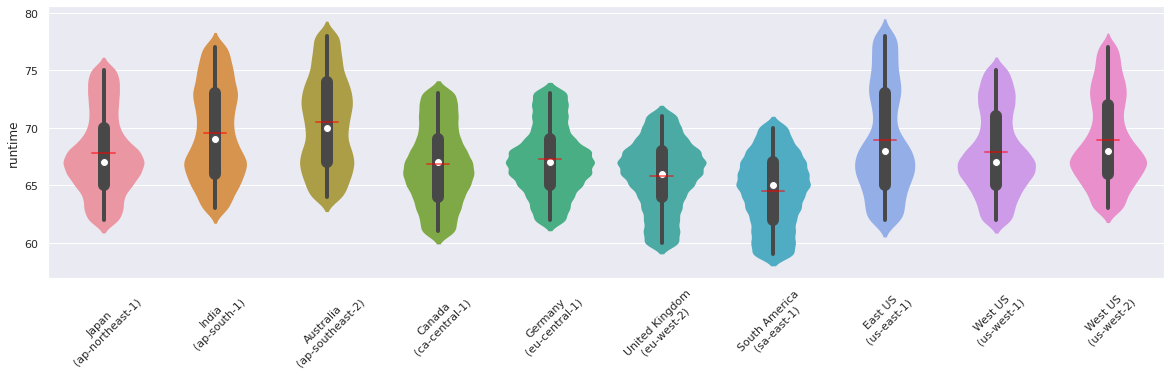

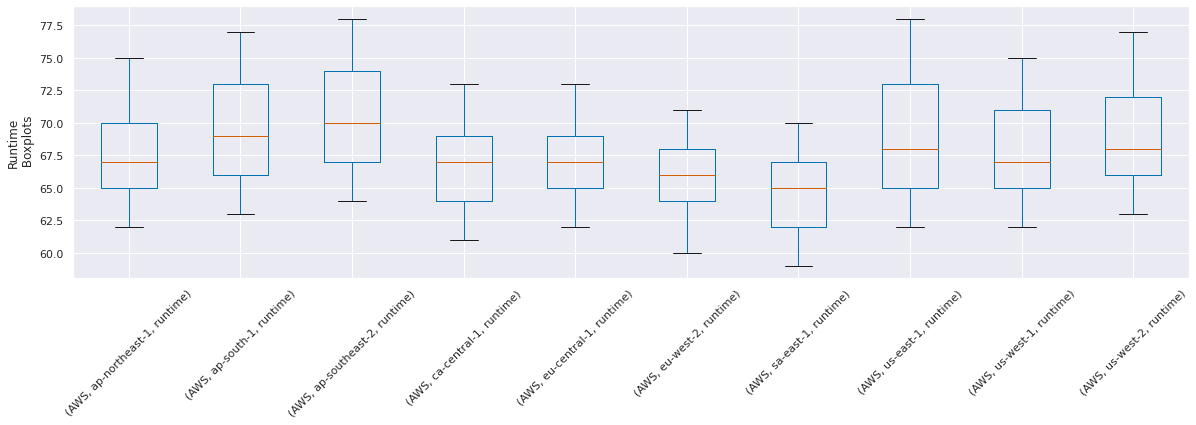

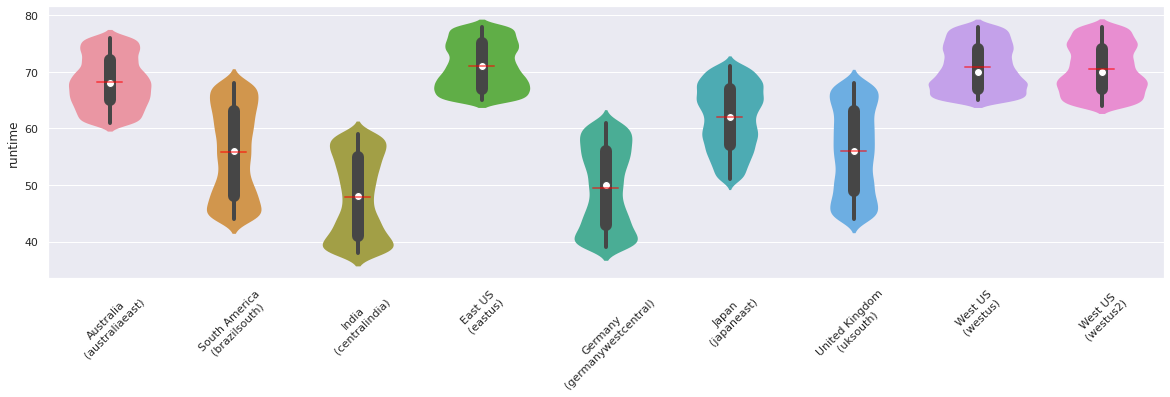

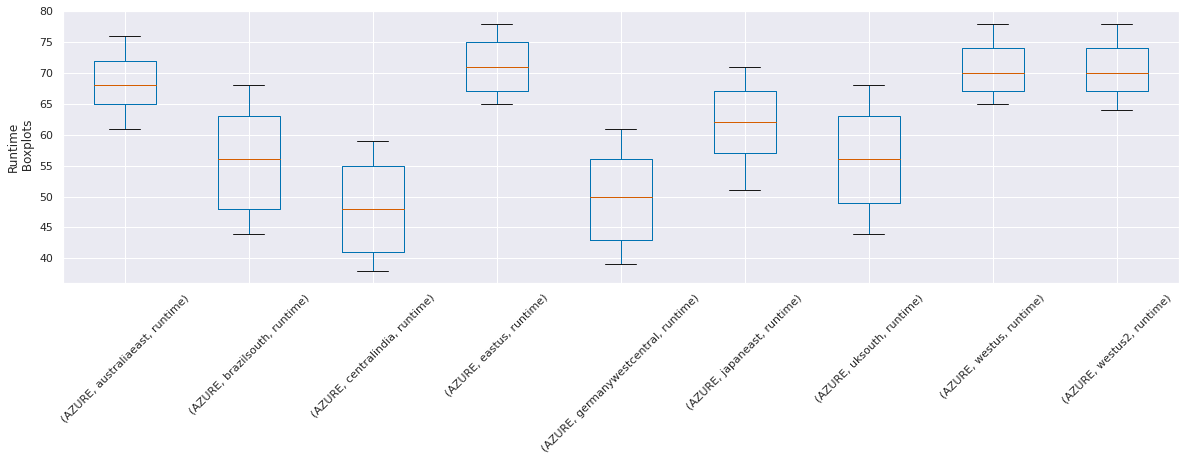

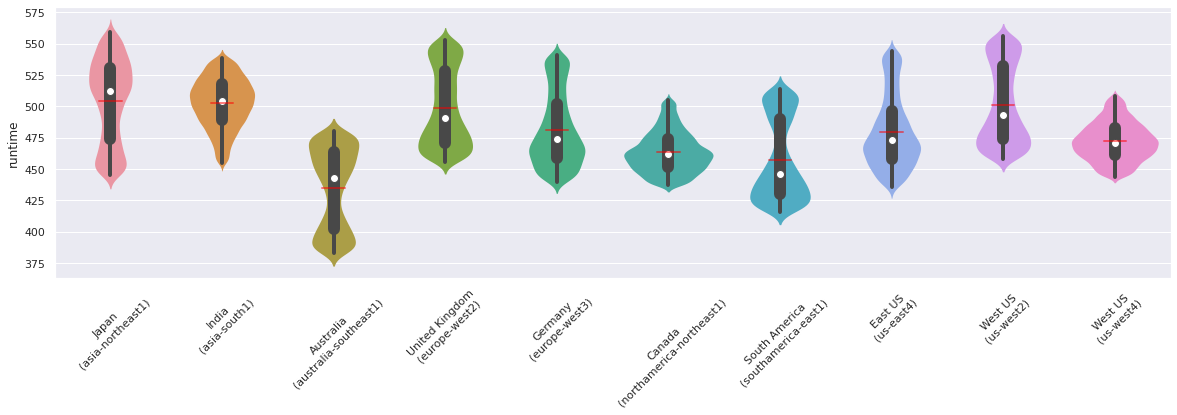

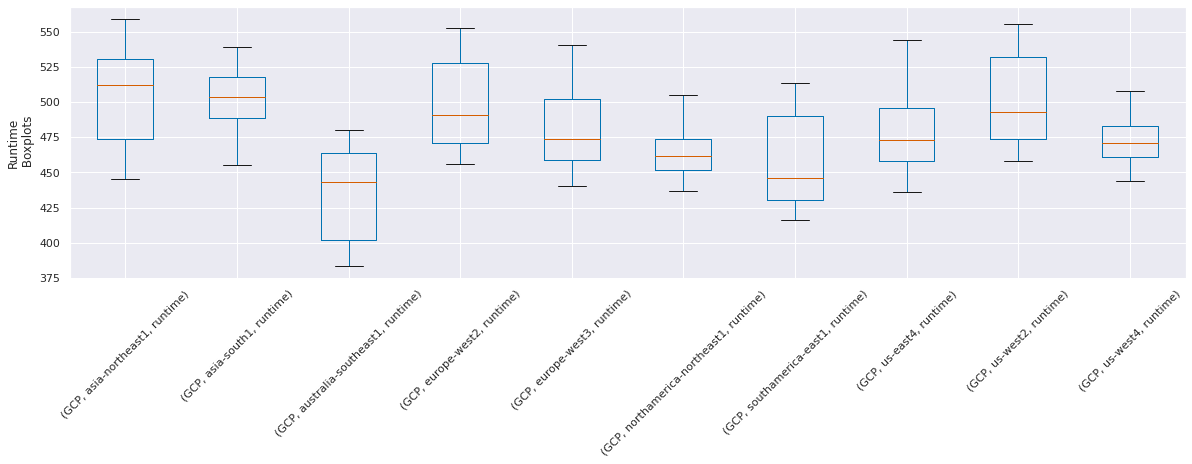

In [8]:
    
for provider in df['provider'].unique():
    SHAREX = True
    pdf = df[['provider', 'region', 'runtime']][df['provider'] == provider]
    regions = (pdf['region'].unique())
    no_regions = len(regions)
    fig, axes = plt.subplots(figsize=(20,5)) #, ncols=no_regions, frameon=False, sharex=SHAREX, sharey=True)
    index = 0
    pdf = utils.remove_outliers_group_quantiles(pdf, 'region', 'runtime')
    ax = violinplotutil.vioplot(pdf, axes, 'runtime')
    
    region_name_ax = ax
    labels = []
    for tick in region_name_ax.get_xticklabels():
        region = tick.get_text()
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        measure_group = mapping['measure group']
        labels.append(f"{measure_group}\n({region})")
    region_name_ax.set_xticklabels(labels, rotation=45)
    region_name_ax.set_xlabel('')
    
    fig, axes = plt.subplots(figsize=(20,5)) #, ncols=no_regions, frameon=False, sharex=SHAREX, sharey=True)
    bxdf = pdf.groupby(['provider','region'], observed=True)
    utils.boxplot(axes, bxdf, "Runtime\n Boxplots", lambda x: x, rot=45, sharex=False)


In [9]:
cov_df

provider  region                 
AWS       ap-northeast-1             0.165571
          ap-south-1                 0.154348
          ap-southeast-2             0.148271
          ca-central-1               0.160348
          eu-central-1               0.140846
          eu-west-2                  0.158220
          sa-east-1                  0.141469
          us-east-1                  0.146367
          us-west-1                  0.159309
          us-west-2                  0.155718
AZURE     australiaeast              0.212299
          brazilsouth                0.285020
          centralindia               0.288369
          eastus                     0.194296
          germanywestcentral         0.298079
          japaneast                  0.263333
          uksouth                    0.292802
          westus                     0.469833
          westus2                    0.204967
GCP       asia-northeast1            0.259231
          asia-south1                0.154905


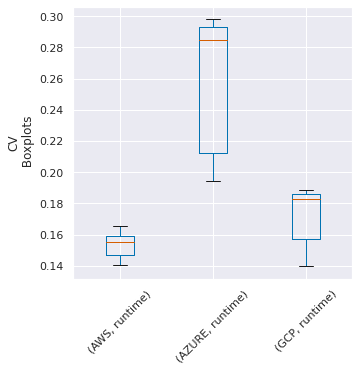

cvbx 
          runtime                                                              \
           count      mean       std       min       25%       50%       75%   
provider                                                                       
AWS         10.0  0.153047  0.008402  0.140846  0.146843  0.155033  0.159037   
AZURE        9.0  0.278778  0.082497  0.194296  0.212299  0.285020  0.292802   
GCP         10.0  0.178403  0.034148  0.139732  0.157380  0.182922  0.185935   

                    
               max  
provider            
AWS       0.165571  
AZURE     0.469833  
GCP       0.259231  


In [10]:
# CV Boxplots
cov_df.groupby('provider')
fig, axes = plt.subplots(figsize=(5,5))
    
bxdf = cov_df.reset_index().groupby(['provider'])
utils.boxplot(axes, bxdf, "CV\n Boxplots", lambda x: x, rot=45)
utils.plot( ['region_analysis', f'cv_boxplot'], cvbx=bxdf.describe())

In [11]:
mean_region_df = df[['provider', 'region', 'runtime']].groupby(['provider', 'region'], observed=True).mean()
mean_region_df

runtime
provider region                             
AWS      ap-northeast-1            69.449914
         ap-south-1                70.704676
         ap-southeast-2            71.127482
         ca-central-1              68.036762
         eu-central-1              68.289983
         eu-west-2                  67.14103
         sa-east-1                 65.866563
         us-east-1                  70.22884
         us-west-1                 69.494815
         us-west-2                 70.398706
AZURE    australiaeast             69.747765
         brazilsouth               57.161206
         centralindia              49.828362
         eastus                    73.323414
         germanywestcentral        51.202322
         japaneast                 61.974789
         uksouth                    57.48951
         westus                    72.765148
         westus2                   72.876197
GCP      asia-northeast1          512.240703
         asia-south1              504.527383
         australia-southeast1     436.331456
         europe-west2             498.717184
         europe-west3              484.63512
         northamerica-northeast1  465.446092
         southamerica-east1       456.039949
         us-east4                 485.229845
         us-west2                 499.634598
         us-west4                 472.868161

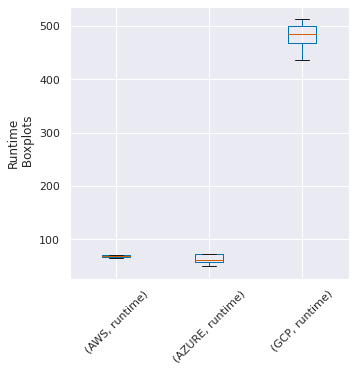

cvbx 
          runtime                                                             \
           count        mean        std         min         25%         50%   
provider                                                                      
AWS         10.0   69.073877   1.699587   65.866563   68.100067   69.472364   
AZURE        9.0   62.929857   9.507521   49.828362   57.161206   61.974789   
GCP         10.0  481.567049  23.909297  436.331456  467.301609  484.932483   

                                  
                 75%         max  
provider                          
AWS        70.356240   71.127482  
AZURE      72.765148   73.323414  
GCP       499.405244  512.240703  


In [12]:
# Runtime Boxplots
fig, axes = plt.subplots(figsize=(5,5))
    
bxdf = mean_region_df.groupby('provider')
utils.boxplot(axes, bxdf, "Runtime\n Boxplots", lambda x: x, rot=45)
utils.plot( ['region_analysis', f'runtime_boxplot'], cvbx=bxdf.describe())

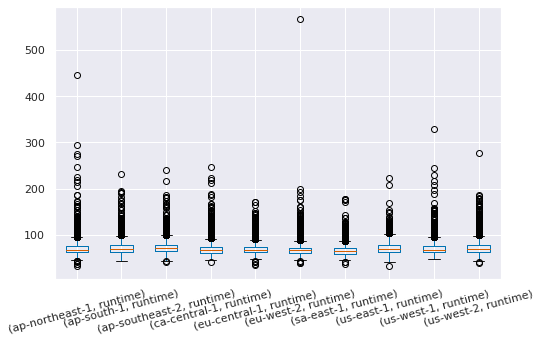

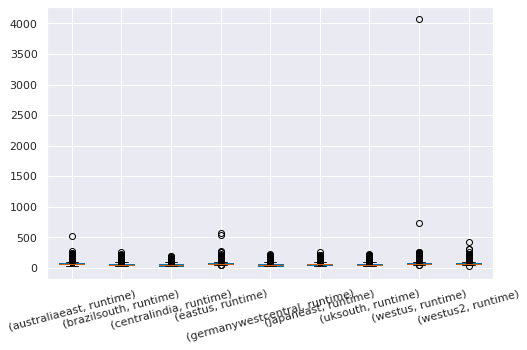

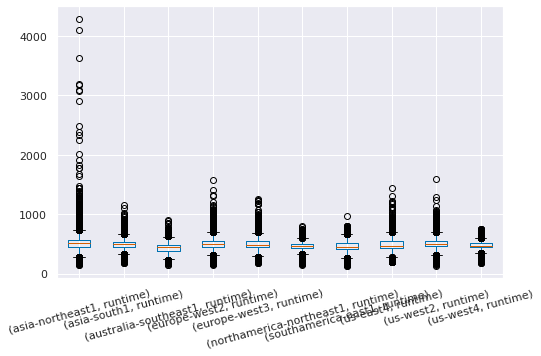

In [13]:
# Mean Runtime with Outliers
for provider in cov_df.index.get_level_values('provider').unique():
# Generate a control figure - because I cannot fore the matching
    fig, axes = plt.subplots(figsize=(8,5))
    df[['provider', 'region', 'runtime']][df['provider'] == provider].groupby(['region'], observed=True).boxplot(subplots=False, ax=axes, rot=45)
    for tick in axes.get_xticklabels():
        tick.set_rotation(15)
    plt.show()
    plt.close()

# CPU Types Analysis
Different Types of CPUs for the different regions.

In [14]:
unique_cpu_types_df = df.groupby(['provider', 'region', 'cpuType'], observed=True)['cpuType'].count() #.agg({'cpuType':'count'})
unique_cpu_types_df = pd.DataFrame(unique_cpu_types_df).groupby(['provider', 'region'], group_keys=False).apply(lambda df: (df['cpuType'] / df['cpuType'].sum()) * 100)
unique_cpu_types_percentage_df = pd.DataFrame(unique_cpu_types_df)
unique_cpu_types_percentage_df = unique_cpu_types_percentage_df.rename(columns={'cpuType': 'Percentage'})
unique_cpu_types_percentage_df = unique_cpu_types_percentage_df.reset_index('cpuType')
unique_cpu_types_pivoted_df = unique_cpu_types_percentage_df.pivot(columns=['cpuType'])

In [15]:
cpu_map = {
    "Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63": "Xeon @ 2.50GHz - Model 63",
    "Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz - Model 85": "Xeon Platinum 8171M CPU @ 2.60GHz - Model 85",
    "Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Model 79": "Xeon CPU E5-2673 v4 @ 2.30GHz - Model 79",
    "Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz - Model 85": "Xeon Platinum 8272CL CPU @ 2.60GHz - Model 85",
    "Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Model 63": "Xeon CPU E5-2673 v3 @ 2.40GHz - Model 63",
    "Intel(R) Xeon(R) Processor @ 3.00GHz - Model 63": "Xeon @ 3.00GHz - Model 63",
    "unknown - Model 85": "Model 85",
    "unknown - Model 79": "Model 79",
    "unknown - Model 63": "Model 63"
}

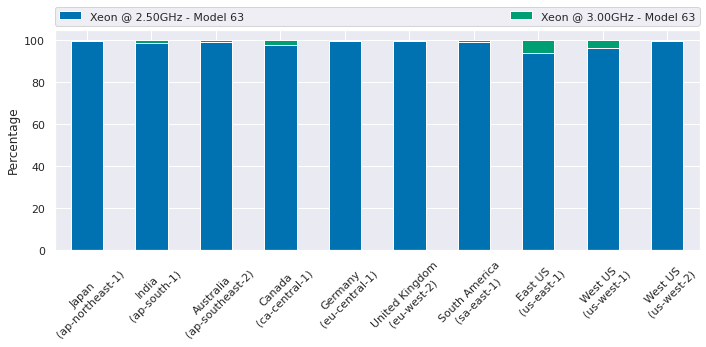

cpu_types_percentrage 
                 Xeon @ 2.50GHz - Model 63  Xeon @ 3.00GHz - Model 63
region                                                              
ap-northeast-1                  99.539436                   0.460564
ap-south-1                      98.658143                   1.341857
ap-southeast-2                  99.021583                   0.978417
ca-central-1                    97.670003                   2.329997
eu-central-1                    99.712147                   0.287853
eu-west-2                       99.953912                   0.046088
sa-east-1                       99.343469                   0.656531
us-east-1                       94.003120                   5.996880
us-west-1                       96.549142                   3.450858
us-west-2                       99.965350                   0.034650


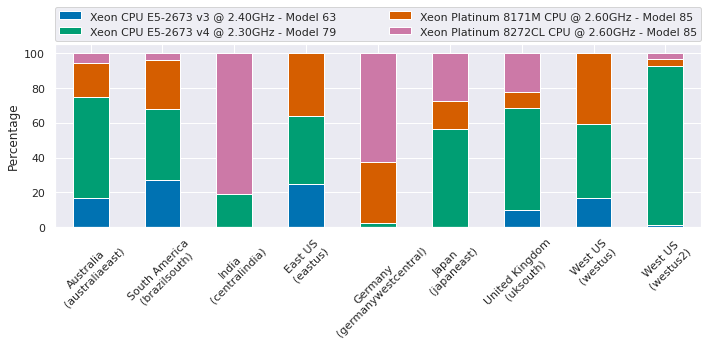

cpu_types_percentrage 
                     Xeon CPU E5-2673 v3 @ 2.40GHz - Model 63  \
region                                                         
australiaeast                                      16.847237   
brazilsouth                                        26.970616   
centralindia                                        0.323737   
eastus                                             24.811459   
germanywestcentral                                       NaN   
japaneast                                           0.057824   
uksouth                                            10.160088   
westus                                             16.741396   
westus2                                             1.160833   

                    Xeon CPU E5-2673 v4 @ 2.30GHz - Model 79  \
region                                                         
australiaeast                                      57.868364   
brazilsouth                                        40.689132   
centralindia   

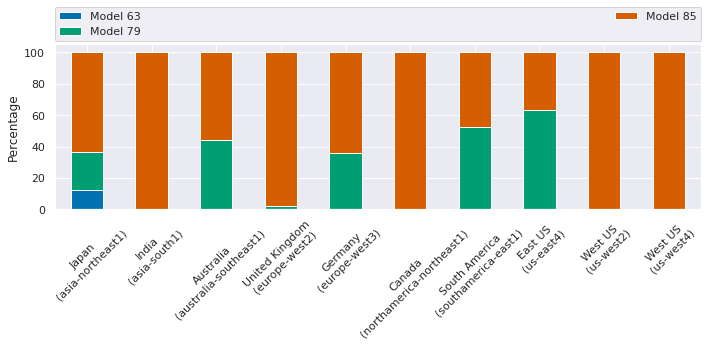

cpu_types_percentrage 
                           Model 63   Model 79    Model 85
region                                                   
asia-northeast1          12.207598  24.622105   63.170297
asia-south1                    NaN        NaN  100.000000
australia-southeast1           NaN  44.096524   55.903476
europe-west2                   NaN   2.091954   97.908046
europe-west3                   NaN  36.057002   63.942998
northamerica-northeast1        NaN        NaN  100.000000
southamerica-east1             NaN  52.296373   47.703627
us-east4                       NaN  63.603976   36.396024
us-west2                       NaN        NaN  100.000000
us-west4                       NaN        NaN  100.000000


In [16]:
for provider in df['provider'].unique():
    fig, axes = plt.subplots(figsize=(10,5))
    subdf = unique_cpu_types_pivoted_df

    providerdf = subdf.loc[provider]

    cols = providerdf.columns.droplevel(0)
    new_cols = [cpu_map[x] for x in cols]
    providerdf.columns = new_cols
    providerdf = providerdf.dropna(axis=1, how='all')
    
    providerdf.plot.bar(stacked=True, ax=axes, rot=45)

    axes.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)
    axes.set_xlabel('')
    axes.set_ylabel('Percentage')
    
    # Set Region Names
    labels = []
    for tick in axes.get_xticklabels():
        region = tick.get_text()
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        measure_group = mapping['measure group']
        labels.append(f"{measure_group}\n({region})")
    axes.set_xticklabels(labels)
    
    fig.tight_layout()
    utils.plot( ['region_analysis', f'cpu_types_{provider}'], cpu_types_percentrage=providerdf)

In [17]:
cputype_per_invocation_df = pd.DataFrame(df.groupby(['provider', 'region', 'driver_invocation'], observed=True)['cpuType'].nunique().rename('Count'))

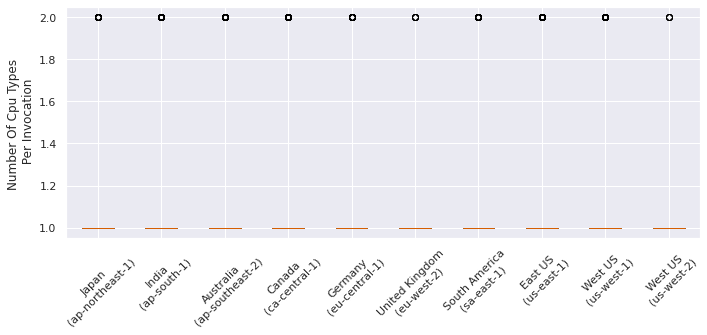

cputype_per_invocation_df 
                  Count                                             
                 count      mean       std  min  25%  50%  75%  max
region                                                             
ap-northeast-1  2895.0  1.013126  0.113834  1.0  1.0  1.0  1.0  2.0
ap-south-1      2894.0  1.038701  0.192914  1.0  1.0  1.0  1.0  2.0
ap-southeast-2  2896.0  1.027970  0.164914  1.0  1.0  1.0  1.0  2.0
ca-central-1    2897.0  1.066275  0.248806  1.0  1.0  1.0  1.0  2.0
eu-central-1    2895.0  1.008636  0.092542  1.0  1.0  1.0  1.0  2.0
eu-west-2       2893.0  1.001728  0.041544  1.0  1.0  1.0  1.0  2.0
sa-east-1       2893.0  1.018666  0.135365  1.0  1.0  1.0  1.0  2.0
us-east-1       2885.0  1.134835  0.341607  1.0  1.0  1.0  1.0  2.0
us-west-1       2893.0  1.081922  0.274293  1.0  1.0  1.0  1.0  2.0
us-west-2       2886.0  1.001386  0.037210  1.0  1.0  1.0  1.0  2.0


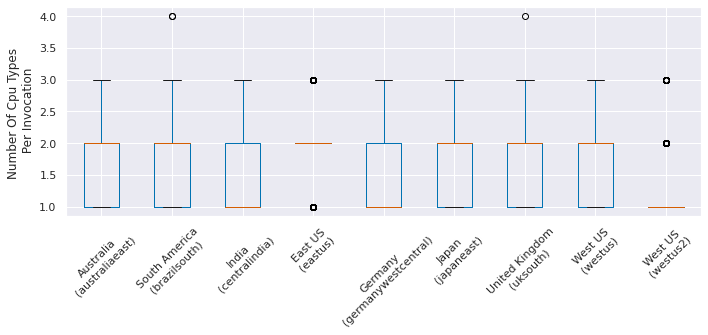

cputype_per_invocation_df 
                      Count                                             
                     count      mean       std  min  25%  50%  75%  max
region                                                                 
australiaeast       2875.0  1.661565  0.608940  1.0  1.0  2.0  2.0  3.0
brazilsouth         2878.0  1.773454  0.614474  1.0  1.0  2.0  2.0  4.0
centralindia        2895.0  1.338515  0.476923  1.0  1.0  1.0  2.0  3.0
eastus              2871.0  1.935563  0.588827  1.0  2.0  2.0  2.0  3.0
germanywestcentral  2897.0  1.489472  0.516285  1.0  1.0  1.0  2.0  3.0
japaneast           2894.0  1.747754  0.595484  1.0  1.0  2.0  2.0  3.0
uksouth             2893.0  1.751469  0.608920  1.0  1.0  2.0  2.0  4.0
westus              2836.0  1.820522  0.594402  1.0  1.0  2.0  2.0  3.0
westus2             2896.0  1.194061  0.424198  1.0  1.0  1.0  1.0  3.0


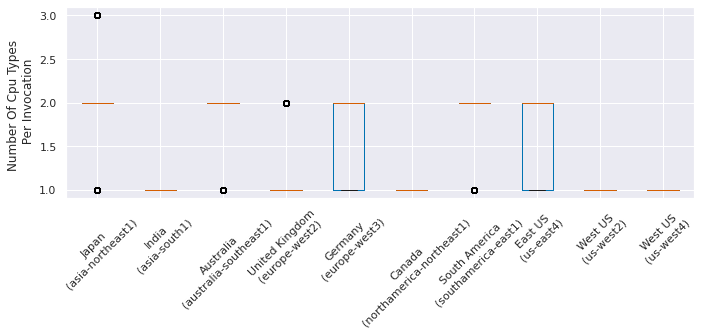

cputype_per_invocation_df 
                           Count                                             
                          count      mean       std  min  25%  50%  75%  max
region                                                                      
asia-northeast1          2900.0  1.953793  0.625934  1.0  2.0  2.0  2.0  3.0
asia-south1              2901.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
australia-southeast1     2901.0  1.802827  0.397933  1.0  2.0  2.0  2.0  2.0
europe-west2             2901.0  1.084454  0.278115  1.0  1.0  1.0  1.0  2.0
europe-west3             2901.0  1.685281  0.464484  1.0  1.0  2.0  2.0  2.0
northamerica-northeast1  2901.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
southamerica-east1       2900.0  1.860000  0.347047  1.0  2.0  2.0  2.0  2.0
us-east4                 2901.0  1.635643  0.481332  1.0  1.0  2.0  2.0  2.0
us-west2                 2900.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
us-west4                 2900.0  1.000000  0.000

In [18]:
for provider in df['provider'].unique():
    fig, axes = plt.subplots(figsize=(10,5))
    subdf = cputype_per_invocation_df
    provdf = subdf.loc[provider]
    provdf.boxplot(by='region', rot=45, ax=axes)
    
    # Set Region Names
    labels = []
    for tick in axes.get_xticklabels():
        region = tick.get_text()
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        measure_group = mapping['measure group']
        labels.append(f"{measure_group}\n({region})")
    axes.set_xticklabels(labels)
    
    # Other Formatting
    axes.set_title('')
    fig.suptitle('')
    axes.set_xlabel('')
    axes.set_ylabel('Number Of Cpu Types \n Per Invocation')
    
    fig.tight_layout()
    utils.plot( ['region_analysis', f'invocation_cpu_types_{provider}'], cputype_per_invocation_df=provdf.groupby('region').describe())